In [1]:
import stim 
import networkx as nx

import numpy as np

# Qubit labeling: q0, q1, q2, q3
# Checks: cx0, cx1 for X checks; cz0 for Z check
Hx = np.array([
    [1, 1, 0, 0],  # X1 X2
    [0, 0, 1, 1],  # X3 X4
])

Hz = np.array([
    [1, 1, 1, 1],  # Z1 Z2 Z3 Z4
])

def tanner_graph(H, check_prefix):
    G = nx.Graph()
    n_checks, n_qubits = H.shape
    for i in range(n_checks):
        for j in range(n_qubits):
            if H[i, j] == 1:
                G.add_edge(f"{check_prefix}{i}", f"q{j}")
    return G

Gx = tanner_graph(Hx, "cx")
Gz = tanner_graph(Hz, "cz")

In [2]:
Gx.degree, Gz.degree

(DegreeView({'cx0': 2, 'q0': 1, 'q1': 1, 'cx1': 2, 'q2': 1, 'q3': 1}),
 DegreeView({'cz0': 4, 'q0': 1, 'q1': 1, 'q2': 1, 'q3': 1}))

In [3]:
from graphs import edge_coloring
edge_color_bipartite = edge_coloring.edge_color_bipartite
colorings_x = edge_color_bipartite(Gx)
colorings_z = edge_color_bipartite(Gz)
colorings_x, colorings_z

([{('cx0', 'q0'), ('cx1', 'q2')}, {('cx0', 'q1'), ('cx1', 'q3')}],
 [{('cz0', 'q0')}, {('cz0', 'q1')}, {('cz0', 'q2')}, {('cz0', 'q3')}])

In [4]:
from css import *

In [5]:
sfcode = SurfaceCode(d=3)

In [6]:
sfcode

CSS code: [[9, 1, d]]

In [7]:
sfcode.H_X

array([[1, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 1]], dtype=uint8)

In [8]:
sfcode.H_Z

array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)

In [9]:
sfcode.L_X, sfcode.L_Z

(array([[0, 0, 0, 0, 0, 0, 1, 1, 1]], dtype=uint8),
 array([[1, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=uint8))

In [10]:
#cmt, Lz is diagonal 

In [11]:
def syndrome_extraction_circuit(ancillas, qubit_index, colorings_x, colorings_z, p1,  p2,  with_noise=True):
    circuit = stim.Circuit()
    # Intialize ancillas
    circuit.append("R", ancillas)
    circuit.append("H", ancillas)
    if with_noise:
        circuit.append("DEPOLARIZE1", ancillas, p1)

    # X checks
    for edges in colorings_x:
        for c, q in edges:
            c_idx = qubit_index[c]
            q_idx = qubit_index[q]
            circuit.append("H", [q_idx])
            if with_noise:
                circuit.append("DEPOLARIZE1", [q_idx], p1)
            circuit.append("CZ", [c_idx, q_idx])
            if with_noise:
                circuit.append("DEPOLARIZE2", [c_idx, q_idx], p2)
            circuit.append("H", [q_idx])
            if with_noise:
                circuit.append("DEPOLARIZE1", [q_idx], p1)

    # Z checks
    for edges in colorings_z:
        for c, q in edges:
            c_idx = qubit_index[c]
            q_idx = qubit_index[q]
            circuit.append("CZ", [c_idx, q_idx])
            if with_noise:
                circuit.append("DEPOLARIZE2", [c_idx, q_idx], p2)

    circuit.append("H", ancillas)
    if with_noise:
        circuit.append("DEPOLARIZE1", ancillas, p1)
    circuit.append("MR", ancillas)
    
    return circuit


def stim_circuit_from_checks(Hx, Hz, logical_obs_qubits, num_rounds=3,
                             p1=0.001, p2=0.005):  # noise parameters
    circuit = stim.Circuit()

    Gx = tanner_graph(Hx, "cx")
    Gz = tanner_graph(Hz, "cz")
    colorings_x = edge_color_bipartite(Gx)
    colorings_z = edge_color_bipartite(Gz)

    cx, n = Hx.shape
    cz, _ = Hz.shape

    qubit_index = {f"q{i}": i for i in range(n)}
    qubit_index.update({f"cx{i}": n + i for i in range(cx)})
    qubit_index.update({f"cz{i}": n + cx + i for i in range(cz)})
    print(qubit_index)
    print(colorings_x)
    print(colorings_z)
    data = [qubit_index[f"q{i}"] for i in range(n)]
    check_x = [qubit_index[f"cx{i}"] for i in range(cx)]
    check_z = [qubit_index[f"cz{i}"] for i in range(cz)]
    ancillas = check_x + check_z
    total_ancillas = len(ancillas)

    # Init
    circuit.append("R", data)

    circuit += syndrome_extraction_circuit(ancillas, qubit_index, colorings_x, colorings_z, p1,  p2,  with_noise=False)
        

    for _ in range(num_rounds):
        circuit += syndrome_extraction_circuit(ancillas, qubit_index, colorings_x, colorings_z, p1,  p2,  with_noise=True)
        
    circuit += syndrome_extraction_circuit(ancillas, qubit_index, colorings_x, colorings_z, p1,  p2,  with_noise=False)


    # DETECTORS: compare ancilla measurements between rounds
    for r in range(num_rounds + 1):
        for i in range(total_ancillas):
            a = -(num_rounds - r+2) * total_ancillas + i
            b = a + total_ancillas
            circuit.append("DETECTOR", [stim.target_rec(a), stim.target_rec(b)])

    # # DETECTORS: compare ancilla measurements between rounds
    # for r in range(num_rounds):
    #     for i in range(total_ancillas):
    #         a = -(num_rounds - r+1) * total_ancillas + i
    #         b = a + total_ancillas
    #         circuit.append("DETECTOR", [stim.target_rec(a), stim.target_rec(b)])

    # LOGICAL observable (Z or X)
    l_qb = list(np.where(logical_obs_qubits == 1)[1])
    print("l_ab", np.where(logical_obs_qubits == 1))
    print("l_ab", logical_obs_qubits)
    circuit.append("M", l_qb)
    obs_targets = [stim.target_rec(-i - 1) for i in range(len(l_qb))]
    circuit.append("OBSERVABLE_INCLUDE", obs_targets, 0)

    return circuit


In [12]:
Hx = sfcode.H_X
Hz = sfcode.H_Z
Lx = sfcode.L_X
Lz = sfcode.L_Z

{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4, 'q5': 5, 'q6': 6, 'q7': 7, 'q8': 8, 'cx0': 9, 'cx1': 10, 'cx2': 11, 'cx3': 12, 'cz0': 13, 'cz1': 14, 'cz2': 15, 'cz3': 16}
[{('cx3', 'q4'), ('cx1', 'q2'), ('cx0', 'q0'), ('cx2', 'q3')}, {('cx0', 'q1'), ('cx2', 'q6'), ('cx1', 'q5'), ('cx3', 'q7')}, {('cx3', 'q5'), ('cx0', 'q3')}, {('cx3', 'q8'), ('cx0', 'q4')}]
[{('cz1', 'q1'), ('cz3', 'q7'), ('cz0', 'q0'), ('cz2', 'q4')}, {('cz0', 'q1'), ('cz2', 'q3'), ('cz3', 'q8'), ('cz1', 'q2')}, {('cz2', 'q6'), ('cz1', 'q4')}, {('cz2', 'q7'), ('cz1', 'q5')}]
l_ab (array([0, 0, 0]), array([0, 4, 8]))
l_ab [[1 0 0 0 1 0 0 0 1]]


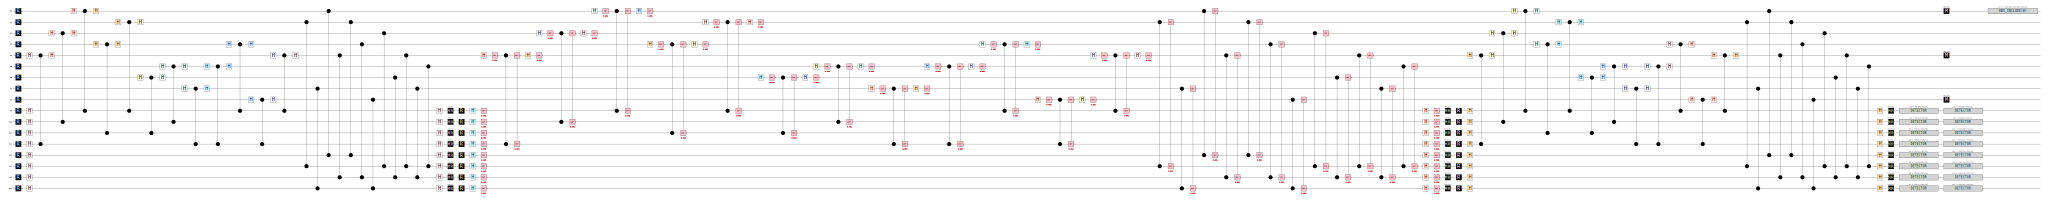

In [23]:
circuit = stim_circuit_from_checks(Hx, Hz, logical_obs_qubits=Lz, num_rounds=1, p1=0.001, p2=0.001)
circuit.diagram("timeline-svg")

In [24]:
# d = 3
# Hx, Hz, Lz, Lx = get_surface_code_operators(d)
print(np.matmul(Hz, Lx.T) % 2)
# circuit = stim_circuit_from_checks(Hx, Hz, logical_obs_qubits=Lz, num_rounds=1, p1=0.001, p2=0.01)
# circuit.diagram("timeline-svg")
circuit.detector_error_model()


[[0]
 [0]
 [0]
 [0]]


stim.DetectorErrorModel('''
    error(0.000866467) D0
    error(0.000466742) D0 D2
    error(0.000466742) D0 D2 D6
    error(0.000466742) D0 D3
    error(0.000466742) D0 D3 D5 D6 L0
    error(0.000400098) D0 D4 D5
    error(6.66978e-05) D0 D4 D5 D8
    error(0.000200067) D0 D4 D8 L0
    error(0.000533378) D0 D4 L0
    error(0.000200067) D0 D5 D6 D8 L0
    error(6.66978e-05) D0 D5 D6 D10 L0
    error(0.000933049) D0 D5 D6 D11 L0
    error(0.000133387) D0 D5 D8 L0
    error(6.66978e-05) D0 D5 D10 L0
    error(6.66978e-05) D0 D5 L0
    error(6.66978e-05) D0 D6 D8
    error(0.000866467) D0 D6 D10
    error(0.00173143) D0 D8
    error(0.000866467) D0 D10
    error(0.000933049) D0 D11
    error(0.000466742) D1
    error(0.000466742) D1 D3
    error(0.000466742) D1 D3 D5
    error(0.000466742) D1 D5
    error(0.000266738) D1 D5 D9
    error(0.00159847) D1 D9
    error(0.000466742) D2
    error(0.000466742) D2 D6
    error(0.000266738) D2 D6 D10
    error(0.00159847) D2 D10
    error(0.0008664

In [26]:
import pymatching

d = 9
sfcode = SurfaceCode(d=d)
Hx = sfcode.H_X
Hz = sfcode.H_Z
Lx = sfcode.L_X
Lz = sfcode.L_Z
noise = 0.001
circuit = stim_circuit_from_checks(
            Hx,
            Hz,
            logical_obs_qubits=Lz,
            num_rounds=d * 3,
            p1=noise,
            p2=noise,
        )

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
sampler = circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=100000, separate_observables=True)

{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4, 'q5': 5, 'q6': 6, 'q7': 7, 'q8': 8, 'q9': 9, 'q10': 10, 'q11': 11, 'q12': 12, 'q13': 13, 'q14': 14, 'q15': 15, 'q16': 16, 'q17': 17, 'q18': 18, 'q19': 19, 'q20': 20, 'q21': 21, 'q22': 22, 'q23': 23, 'q24': 24, 'q25': 25, 'q26': 26, 'q27': 27, 'q28': 28, 'q29': 29, 'q30': 30, 'q31': 31, 'q32': 32, 'q33': 33, 'q34': 34, 'q35': 35, 'q36': 36, 'q37': 37, 'q38': 38, 'q39': 39, 'q40': 40, 'q41': 41, 'q42': 42, 'q43': 43, 'q44': 44, 'q45': 45, 'q46': 46, 'q47': 47, 'q48': 48, 'q49': 49, 'q50': 50, 'q51': 51, 'q52': 52, 'q53': 53, 'q54': 54, 'q55': 55, 'q56': 56, 'q57': 57, 'q58': 58, 'q59': 59, 'q60': 60, 'q61': 61, 'q62': 62, 'q63': 63, 'q64': 64, 'q65': 65, 'q66': 66, 'q67': 67, 'q68': 68, 'q69': 69, 'q70': 70, 'q71': 71, 'q72': 72, 'q73': 73, 'q74': 74, 'q75': 75, 'q76': 76, 'q77': 77, 'q78': 78, 'q79': 79, 'q80': 80, 'cx0': 81, 'cx1': 82, 'cx2': 83, 'cx3': 84, 'cx4': 85, 'cx5': 86, 'cx6': 87, 'cx7': 88, 'cx8': 89, 'cx9': 90, 'cx10': 91, 'cx11'

In [27]:
num_errors = 0
for i in range(syndrome.shape[0]):
    predicted_observables = matching.decode(syndrome[i, :])
    num_errors += not np.array_equal(actual_observables[i, :], predicted_observables)

print(num_errors)  # prints 8

19


In [22]:
circuit.diagram("timeline-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":12,"max":[0,0.5,0.5],"min":[0,-0.5,-0.5],"name":"cube","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":12,"max":[0.375,0.5625],"min":[0.3125,0.5],"name":"tex_coords_gate_R","type":"VEC2"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":12,"max":[0.125,0.5],"min":[0.0625,0.4375],"name":"tex_coords_gate_H","type":"VEC2"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":12,"max":[0.4375,0.5625],"min":[0.375,0.5],"name":"tex_coords_gate_MR","type":"VEC2"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":12,"max":[0.25,0.625],"min":[0.1875,0.5625],"name":"tex_coords_gate_DEPOLARIZE1","type":"VEC2"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.625],"min":[0.25,0.5625],"name":"tex_coords_gate_DEPOLARIZE2","type":"VEC2"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.5625],"min":[0.25,0.5],"name":"tex_coords_gate_M","type":"VEC2"},{"bufferView":8,"byteOffset":0,"componentType":5126,"count":5410,"max":[1,-0,-0],"min":[-2170,-32,-0],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":9,"byteOffset":0,"componentType":5126,"count":6,"max":[0,2.5,-0],"min":[-3,1.5,-0],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":144,"byteOffset":0,"name":"cube","target":34962},{"buffer":1,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_R","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_H","target":34962},{"buffer":3,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_MR","target":34962},{"buffer":5,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_DEPOLARIZE1","target":34962},{"buffer":6,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_DEPOLARIZE2","target":34962},{"buffer":7,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_M","target":34962},{"buffer":8,"byteLength":64920,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":9,"byteLength":72,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":144,"name":"cube","uri":"data:application/octet-stream;base64,AAAAAAAAAD8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAC/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAD8AAAA/"},{"byteLength":96,"name":"tex_coords_gate_R","uri":"data:application/octet-stream;base64,AADAPgAAAD8AAKA+AAAAPwAAwD4AABA/AACgPgAAAD8AAKA+AAAQPwAAwD4AABA/AADAPgAAED8AAMA+AAAAPwAAoD4AABA/AACgPgAAED8AAMA+AAAAPwAAoD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_H","uri":"data:application/octet-stream;base64,AAAAPgAA4D4AAIA9AADgPgAAAD4AAAA/AACAPQAA4D4AAIA9AAAAPwAAAD4AAAA/AAAAPgAAAD8AAAA+AADgPgAAgD0AAAA/AACAPQAAAD8AAAA+AADgPgAAgD0AAOA+"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":96,"name":"tex_coords_gate_MR","uri":"data:application/octet-stream;base64,AADgPgAAAD8AAMA+AAAAPwAA4D4AABA/AADAPgAAAD8AAMA+AAAQPwAA4D4AABA/AADgPgAAED8AAOA+AAAAPwAAwD4AABA/AADAPgAAED8AAOA+AAAAPwAAwD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_DEPOLARIZE1","uri":"data:application/octet-stream;base64,AACAPgAAED8AAEA+AAAQPwAAgD4AACA/AABAPgAAED8AAEA+AAAgPwAAgD4AACA/AACAPgAAID8AAIA+AAAQPwAAQD4AACA/AABAPgAAID8AAIA+AAAQPwAAQD4AABA/"},{"byteLength":96,"name":"tex_coords

Running distance d=3...
  Testing noise rate p=0.001...
{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4, 'q5': 5, 'q6': 6, 'q7': 7, 'q8': 8, 'cx0': 9, 'cx1': 10, 'cx2': 11, 'cx3': 12, 'cz0': 13, 'cz1': 14, 'cz2': 15, 'cz3': 16}
[{('cx3', 'q4'), ('cx1', 'q2'), ('cx0', 'q0'), ('cx2', 'q3')}, {('cx0', 'q1'), ('cx2', 'q6'), ('cx1', 'q5'), ('cx3', 'q7')}, {('cx3', 'q5'), ('cx0', 'q3')}, {('cx3', 'q8'), ('cx0', 'q4')}]
[{('cz1', 'q1'), ('cz3', 'q7'), ('cz0', 'q0'), ('cz2', 'q4')}, {('cz0', 'q1'), ('cz2', 'q3'), ('cz3', 'q8'), ('cz1', 'q2')}, {('cz2', 'q6'), ('cz1', 'q4')}, {('cz2', 'q7'), ('cz1', 'q5')}]
l_ab (array([0, 0, 0]), array([0, 4, 8]))
l_ab [[1 0 0 0 1 0 0 0 1]]
    Logical error rate: 0.0551
  Testing noise rate p=0.005...
{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4, 'q5': 5, 'q6': 6, 'q7': 7, 'q8': 8, 'cx0': 9, 'cx1': 10, 'cx2': 11, 'cx3': 12, 'cz0': 13, 'cz1': 14, 'cz2': 15, 'cz3': 16}
[{('cx3', 'q4'), ('cx1', 'q2'), ('cx0', 'q0'), ('cx2', 'q3')}, {('cx0', 'q1'), ('cx2', 'q6'), ('

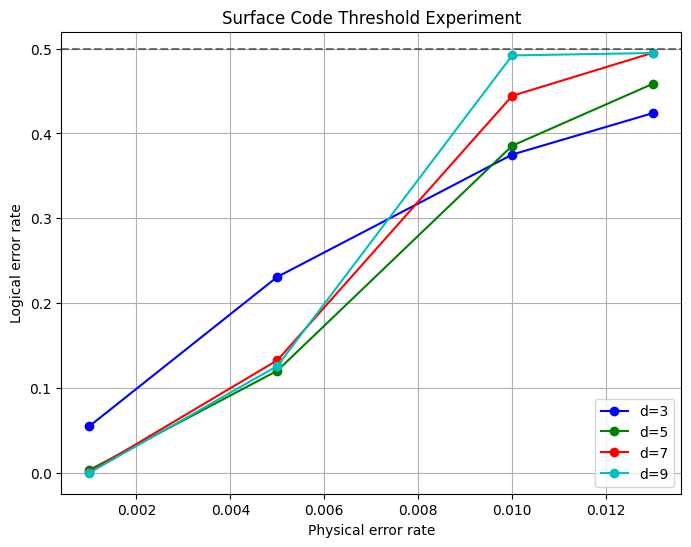

In [28]:
import matplotlib.pyplot as plt

def run_threshold_experiment():
    # Parameters
    distances = [3, 5, 7, 9]
    noise_rates = [0.001, 0.005, 0.01, 0.013]
    shots_per_config = 10000  # 
    
    # Store results: logical_error_rates[d_idx][noise_idx]
    logical_error_rates = np.zeros((len(distances), len(noise_rates)))
    
    for d_idx, d in enumerate(distances):
        print(f"Running distance d={d}...")
        
        # Initialize surface code
        sfcode = SurfaceCode(d=d)
        Hx = sfcode.H_X
        Hz = sfcode.H_Z
        Lx = sfcode.L_X
        Lz = sfcode.L_Z
        
        for noise_idx, noise in enumerate(noise_rates):
            print(f"  Testing noise rate p={noise:.3f}...")
            
            # Create circuit
            circuit = stim_circuit_from_checks(
                Hx,
                Hz,
                logical_obs_qubits=Lz,
                num_rounds=d * 3,  # Typically scale rounds with distance
                p1=noise,
                p2=noise,
            )
            
            # Create matching model
            model = circuit.detector_error_model(decompose_errors=True)
            matching = pymatching.Matching.from_detector_error_model(model)
            
            # Sample and decode
            sampler = circuit.compile_detector_sampler()
            syndrome, actual_observables = sampler.sample(shots=shots_per_config, separate_observables=True)
            
            # Decode and count errors
            predicted_observables = matching.decode_batch(syndrome)
            errors = np.any(predicted_observables != actual_observables, axis=1)
            error_rate = np.mean(errors)
            
            logical_error_rates[d_idx, noise_idx] = error_rate
            print(f"    Logical error rate: {error_rate:.4f}")
    
    return distances, noise_rates, logical_error_rates

def plot_threshold_results(distances, noise_rates, logical_error_rates):
    plt.figure(figsize=(8, 6))
    colors = ['b', 'g', 'r', 'c']
    
    for d_idx, d in enumerate(distances):
        plt.plot(noise_rates, logical_error_rates[d_idx], 
                 'o-', color=colors[d_idx], label=f'd={d}')
    
    plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Physical error rate')
    plt.ylabel('Logical error rate')
    plt.title('Surface Code Threshold Experiment')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the experiment
distances, noise_rates, logical_error_rates = run_threshold_experiment()

# Plot results
plot_threshold_results(distances, noise_rates, logical_error_rates)

In [32]:
def run_threshold_toric():
    # Parameters
    distances = [3, 5, 7, 9]
    noise_rates = [0.001, 0.004, 0.007, 0.01, 0.013]
    shots_per_config = 10000  
    
    # Store results: logical_error_rates[d_idx][noise_idx]
    logical_error_rates = np.zeros((len(distances), len(noise_rates)))
    
    for d_idx, d in enumerate(distances):
        print(f"Running distance d={d}...")
        
        # Initialize surface code
        sfcode = ToricCode(d=d)
        Hx = sfcode.H_X
        Hz = sfcode.H_Z
        Lx = sfcode.L_X
        Lz = sfcode.L_Z
        
        for noise_idx, noise in enumerate(noise_rates):
            print(f"  Testing noise rate p={noise:.3f}...")
            
            # Create circuit
            circuit = stim_circuit_from_checks(
                Hx,
                Hz,
                logical_obs_qubits=Lz,
                num_rounds=d * 3, 
                p1=noise,
                p2=noise,
            )
            
            # Create matching model
            model = circuit.detector_error_model(decompose_errors=True)
            matching = pymatching.Matching.from_detector_error_model(model)
            
            # Sample and decode
            sampler = circuit.compile_detector_sampler()
            syndrome, actual_observables = sampler.sample(shots=shots_per_config, separate_observables=True)
            
            # Decode and count errors
            predicted_observables = matching.decode_batch(syndrome)
            errors = np.any(predicted_observables != actual_observables, axis=1)
            error_rate = np.mean(errors)
            
            logical_error_rates[d_idx, noise_idx] = error_rate
            print(f"    Logical error rate: {error_rate:.4f}")
    
    return distances, noise_rates, logical_error_rates



In [33]:
distances, noise_rates, logical_error_rates = run_threshold_toric()

Running distance d=3...
  Testing noise rate p=0.001...
{'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3, 'q4': 4, 'q5': 5, 'q6': 6, 'q7': 7, 'q8': 8, 'q9': 9, 'q10': 10, 'q11': 11, 'q12': 12, 'q13': 13, 'q14': 14, 'q15': 15, 'q16': 16, 'q17': 17, 'cx0': 18, 'cx1': 19, 'cx2': 20, 'cx3': 21, 'cx4': 22, 'cx5': 23, 'cx6': 24, 'cx7': 25, 'cx8': 26, 'cz0': 27, 'cz1': 28, 'cz2': 29, 'cz3': 30, 'cz4': 31, 'cz5': 32, 'cz6': 33, 'cz7': 34, 'cz8': 35}
[{('cx7', 'q1'), ('cx5', 'q5'), ('cx8', 'q2'), ('cx0', 'q0'), ('cx3', 'q3'), ('cx2', 'q11'), ('cx1', 'q9'), ('cx6', 'q6'), ('cx4', 'q4')}, {('cx8', 'q8'), ('cx0', 'q3'), ('cx2', 'q10'), ('cx1', 'q1'), ('cx4', 'q12'), ('cx3', 'q6'), ('cx7', 'q7'), ('cx6', 'q0'), ('cx5', 'q14')}, {('cx8', 'q17'), ('cx7', 'q16'), ('cx2', 'q2'), ('cx5', 'q13'), ('cx4', 'q7'), ('cx3', 'q12'), ('cx1', 'q4'), ('cx6', 'q15'), ('cx0', 'q9')}, {('cx5', 'q8'), ('cx4', 'q13'), ('cx6', 'q17'), ('cx2', 'q5'), ('cx0', 'q11'), ('cx7', 'q15'), ('cx8', 'q16'), ('cx3', 'q14'), ('cx1', 'q10')}]
[{

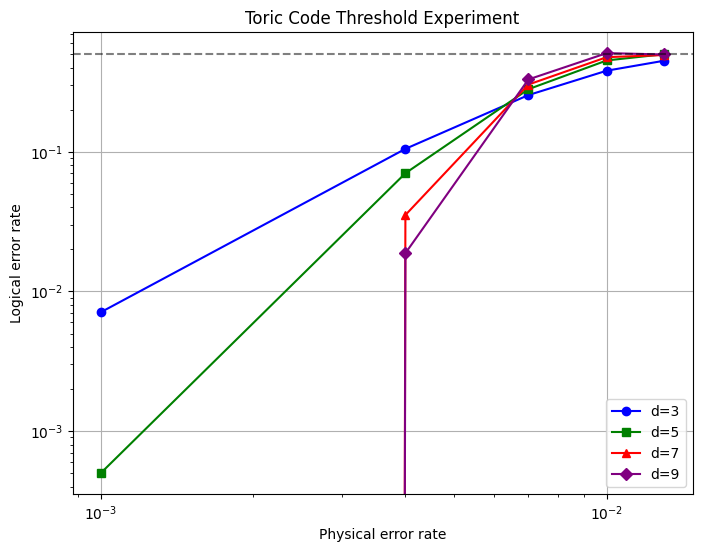

In [34]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'purple']
for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logical_error_rates[d_idx], 
				marker=markers[d_idx], color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Toric Code Threshold Experiment')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.show()